# Dependencies

In [3]:
!pip install tensorflow opencv-python tensorflow-gpu

  Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl.metadata (3.5 kB)
     ---------------------------------------- 0.0/46.2 kB ? eta -:--:--
     -------------------------- ------------- 30.7/46.2 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 46.2/46.2 kB 571.0 kB/s eta 0:00:00
Using cached tensorflow-2.16.1-cp311-cp311-win_amd64.whl (2.1 kB)
   ---------------------------------------- 0.0/377.0 MB ? eta -:--:--
   ---------------------------------------- 0.1/377.0 MB 2.0 MB/s eta 0:03:13
   ---------------------------------------- 0.3/377.0 MB 3.3 MB/s eta 0:01:55
   ---------------------------------------- 0.6/377.0 MB 4.4 MB/s eta 0:01:26
   ---------------------------------------- 1.1/377.0 MB 5.6 MB/s eta 0:01:08
   ---------------------------------------- 1.2/377.0 MB 4.9 MB/s eta 0:01:16
   ---------------------------------------- 1.3/377.0 MB 4.5 MB/s eta 0:01:24
   ---------------------------------------- 1.3/377.0 MB 4.4 MB/s eta 0:01:25
   -----

# Dependencies

In [2]:
import tensorflow as tf
import os

# Gpu config

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus, len(gpus)

([], 0)

In [5]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, true)

In [11]:
import cv2
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [4]:
data_dir = 'data'
valid_image_ext = ['jpg', 'jpeg', 'bmp', 'png']

# Input sieving

In [5]:
def remove_small_images(data_dir, max_size_kb):
    # Convert max_size_kb to bytes
    max_size_bytes = max_size_kb << 10
    
    # Use os.walk to iterate through all files in the directory and subdirectories
    for root, dirs, files in os.walk(data_dir):
        for filename in files:
            file_path = os.path.join(root, filename)
            
            # Check if it's a file and not a directory (redundant check with os.walk, but kept for clarity)
            if os.path.isfile(file_path):
                # Get the file size
                file_size = os.path.getsize(file_path)
                
                # If the file size is not more than max_size_bytes, delete the file
                if file_size <= max_size_bytes:
                    print(f"Removing {file_path}, size: {file_size} bytes")
                    os.remove(file_path)

In [6]:
remove_small_images(data_dir, 9)

In [7]:
def remove_images_with_invalid_ext(data_dir, valid_img_ext):
    for root, dirs, files in os.walk(data_dir):
        for filename in files:
            file_path = os.path.join(root, filename)
            if os.path.isfile(file_path):
                file_ext = os.path.splitext(file_path)[1].lower()[1:]
                if file_ext not in valid_img_ext:
                    print(f"Removing {file_path}, extension: {file_ext}")
                    os.remove(file_path)

In [8]:
remove_images_with_invalid_ext(data_dir, valid_image_ext)

# Reading images

## Seeing one sample image 

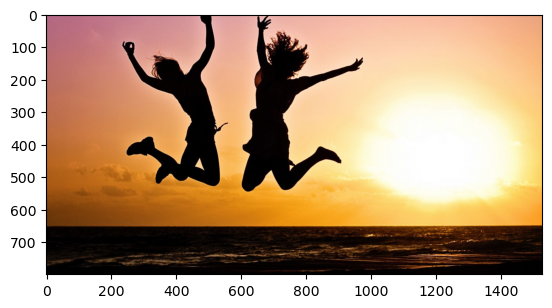

In [9]:
img = cv2.imread(os.path.join('data', 'happy', '_happy_jumping_on_beach-40815.jpg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Load Data

In [10]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    data_types.DatasetV2,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dty

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 195 files belonging to 2 classes.


In [13]:
data_itr = data.as_numpy_iterator()

In [29]:
batch = data_itr.next()

In [20]:
# Images represented as numpy arrays
len(batch), batch[0].shape, batch[1]

(2,
 (32, 256, 256, 3),
 array([1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
        0, 1, 0, 0, 1, 1, 0, 1, 0, 0]))

In [27]:
def check_img_classes(batch, ncols):
    fig, ax = plt.subplots(ncols=ncols, figsize=(20,20))
    for idx, img in enumerate(batch[0][:ncols]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(batch[1][idx])

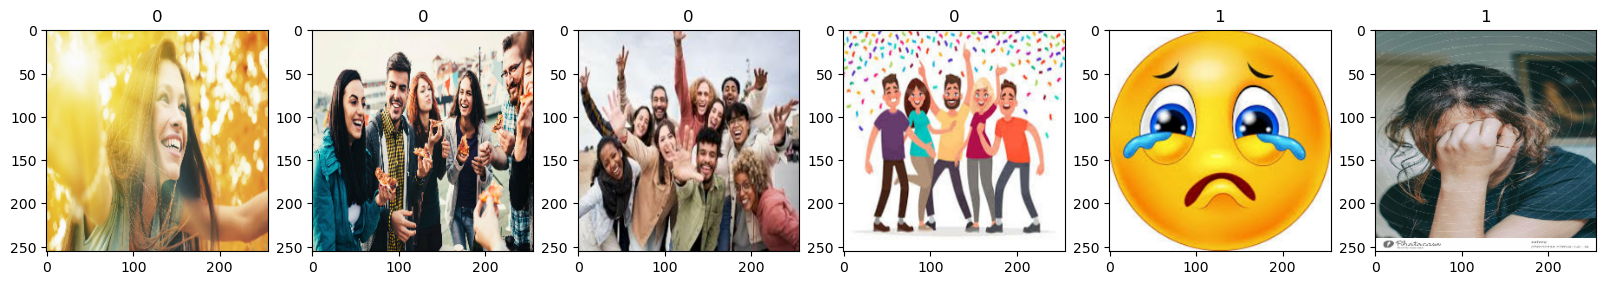

In [30]:
check_img_classes(batch,6)

Class : 1 -> __Sad__
        2 -> __Happy__

# Preprocess data

## Scale Data
batch[0] the data is in range (0, 255)

In [33]:
scaled = batch[0]/batch[0].max()
scaled.min(), scaled.max()

(0.0, 1.0)